# Credit Card Customer Segmentation



In this project, we are tasked with segmenting credit card customers for a bank looking to address a concerning trend of customers leaving its services. We'll utilize a dataset of 10,000 clients, rich with features like age, salary, marital status, and credit card usage, to train a K-means clustering model. The aim is to identify distinct groups within the data, provide actionable insights on each segment, and predict potential churn with the hopes of improving customer retention strategies.

You can find the dataset on [Kaggle](https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers)


We'll start by importing the packages we'll use.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

np.random.seed(42)

sns.set_style('whitegrid')
%matplotlib inline

# Exploratory Data Analysis

After reading the data into pandas, it's time to explore it. Let's investigate the size of the dataset, what columns it contains, the type of values in each column, and also check on missing values.

In [2]:

# Get the column names from the file: read only the first row to avoid loading the entire file into memory
cols = pd.read_csv('dataset/BankChurners.csv', nrows=1).columns

# Exclude the last two columns
cols_to_use = cols[:-2]

# Now, read the file using only the selected columns
customers = pd.read_csv('dataset/BankChurners.csv', usecols=cols_to_use)

# Check the first few rows to confirm
customers.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
customers.shape

(10127, 21)

In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

There are 10127 rows and 14 columns in the dataset including a unique identifier for each client, which is not going to be needed for the segmentation. 

Of the 13 columns left, there are 8 columns containing integers, 2 containing floats, and 3 columns containing strings, which means we have 3 categorical columns to deal with.

Also, there are no missing values.

In [5]:
for col in ['Gender', 'Education_Level', 'Marital_Status']:
    print(col)
    print(customers[col].value_counts(), end='\n\n')

Gender
F    5358
M    4769
Name: Gender, dtype: int64

Education_Level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

Marital_Status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64



Here we can see how many unique categories are there in each categorical variable and how many datapoints per category.

As we're working with unsupervised machine learning, there isn't a target variable on which we can measure the impacts of the other variables.

But we can see the correlation between the numeric variables and their distributions. 

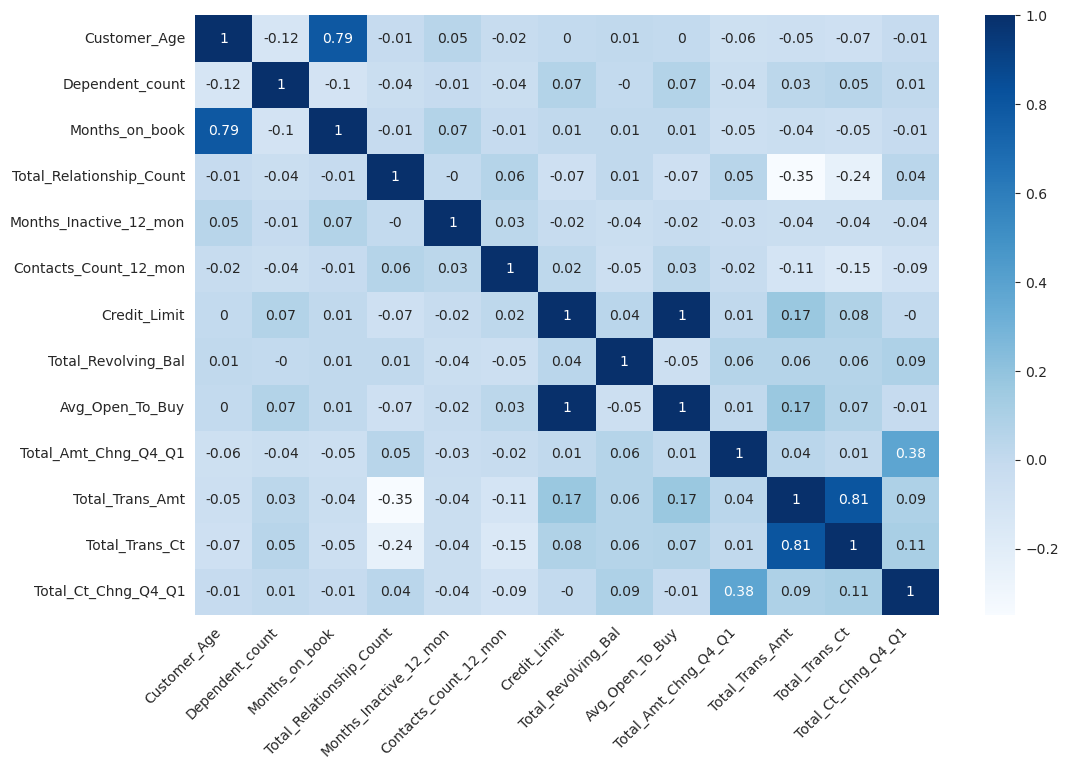

In [34]:
# Select only the numeric columns from the 'customers' DataFrame and drop the 'CLIENTNUM' column
numeric_df = customers.select_dtypes(include=['number']).drop('CLIENTNUM', axis=1)

# Exclude the last two columns and rows which may not be necessary for correlation analysis
numeric_df_adjusted = numeric_df.iloc[:-2, :-2]

# Initialize the plot with a figure size that's large enough for readability
fig, ax = plt.subplots(figsize=(12, 8))

# Create a heatmap of the correlation matrix, rounding the correlation coefficients to 2 decimal places
sns.heatmap(round(numeric_df_adjusted.corr(), 2), cmap='Blues', annot=True, ax=ax)

# Rotate the x-axis labels to 45 degrees for better readability and alignment
plt.xticks(rotation=45, ha='right')

# Adjust the layout of the plot to ensure there is enough space for all plot elements
plt.subplots_adjust(bottom=0.2, top=0.95)

plt.show()





* A darker cell indicates a stronger positive correlation. The value of the correlation coefficient is closer to +1.
* A lighter cell indicates a stronger negative correlation. The value of the correlation coefficient is closer to -1.
* A cell with a neutral color indicates little or no correlation. The value of the correlation coefficient is around 0.

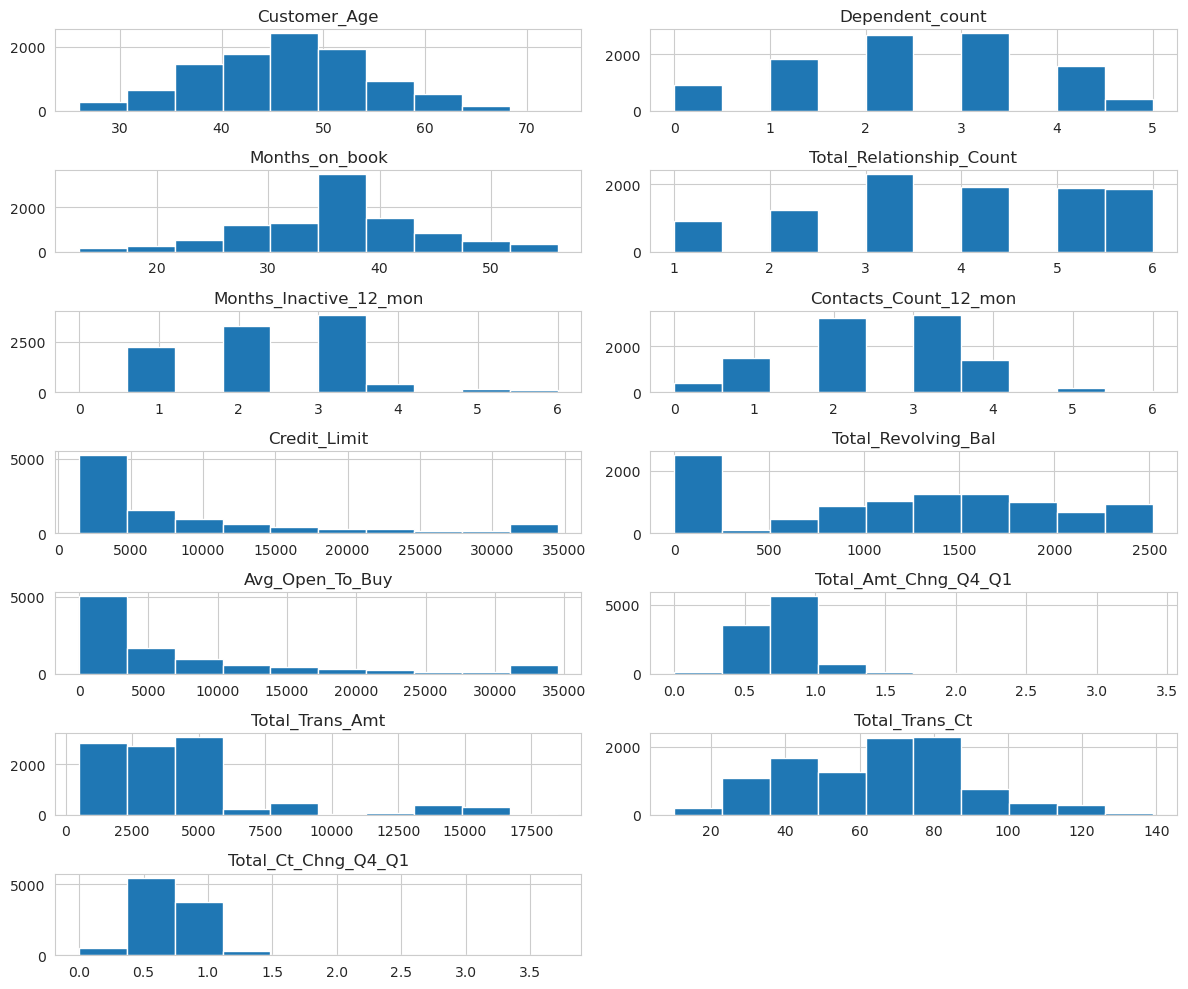

In [19]:
# Select only numerical columns and exclude the last two, as well as 'CLIENTNUM'
numeric_columns = customers.select_dtypes(include=['number']).drop(['CLIENTNUM'], axis=1).iloc[:, :-2].columns
n_cols = len(numeric_columns)
n_rows = (n_cols + 1) // 2  # Calculate the number of rows needed

fig, axs = plt.subplots(n_rows, 2, figsize=(12, 10))  # Set up the subplot grid
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier iteration

# Plot a histogram for each numeric column
for i, col in enumerate(numeric_columns):
    customers[col].hist(ax=axs[i])
    axs[i].set_title(col)

# If the number of numeric columns is odd, remove the last (empty) subplot
if n_cols % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()


Regarding distributions, we have a couple of them closer to a normal distribution, but most of them are skewed.

# Feature Engineering

We're now dealing with the 3 categorical variables.

The `gender` column is the easiest one. We'll use a lambda function to replace the values with ones and zeros.

We'll also be able to transform the `education_level` column to numeric. We'll use the `replace()` method to perform this task. This method will assign a value to each level of education:

* `Uneducated - 0`
* `High School - 1`
* `College - 2`
* `Graduate - 3`
* `Post-Graduate - 4`
* `Doctorate - 5`

Unfortunately, we can't do the same for this marital_status column as there is no level of magnitude between "Single", "Married" or "Divorced", for example. We can't say that any of them is higher or better than the others. Therefore, we'll use one-hot-encoding to create dummy variables from this column and then drop the original variable.

In [8]:
# Make a copy of the customers DataFrame to preserve the original data
customers_modif = customers.copy()

# Apply a function to the 'Gender' column to convert 'M' to 1 and anything else to 0
customers_modif['Gender'] = customers['Gender'].apply(lambda x: 1 if x == 'M' else 0)

# Display the first few rows of the modified DataFrame to verify the changes
customers_modif.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,1,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,0,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,1,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,0,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,1,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [9]:
# Replace the strings in 'Education_Level' with integers as specified
customers_modif.replace(to_replace={
    'Education_Level': {'Uneducated': 0, 'High School': 1, 'College': 2,
                        'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5}
}, inplace=True)

# Display the first few rows of the 'Education_Level' column to verify the changes
customers_modif['Education_Level'].head()


0    1
1    3
2    3
3    1
4    0
Name: Education_Level, dtype: object

In [10]:
# Generate dummy variables for the 'Marital_Status' column, dropping the first category
dummies = pd.get_dummies(customers_modif[['Marital_Status']], drop_first=True)

# Concatenate the dummy variables with the original DataFrame
customers_modif = pd.concat([customers_modif, dummies], axis=1)

# Drop the original 'Marital_Status' column
customers_modif.drop(['Marital_Status'], axis=1, inplace=True)

# Print the shape of the modified DataFrame
print(customers_modif.shape)

# Display the first few rows to verify the changes
customers_modif.head()


(10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
0,768805383,Existing Customer,45,1,3,1,$60K - $80K,Blue,39,5,...,777,11914.0,1.335,1144,42,1.625,0.061,1,0,0
1,818770008,Existing Customer,49,0,5,3,Less than $40K,Blue,44,6,...,864,7392.0,1.541,1291,33,3.714,0.105,0,1,0
2,713982108,Existing Customer,51,1,3,3,$80K - $120K,Blue,36,4,...,0,3418.0,2.594,1887,20,2.333,0.000,1,0,0
3,769911858,Existing Customer,40,0,4,1,Less than $40K,Blue,34,3,...,2517,796.0,1.405,1171,20,2.333,0.760,0,0,1
4,709106358,Existing Customer,40,1,3,0,$60K - $80K,Blue,21,5,...,0,4716.0,2.175,816,28,2.500,0.000,1,0,0


# Scaling the Data

First, we need to standardize the dataset. We'll use scikit-learn's StandardScaler() for this task.

In [11]:
# Select only numerical features for scaling
X_numeric = customers_modif.select_dtypes(include=['number'])

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the numerical features
scaler.fit(X_numeric)

# Transform the numerical features
X_scaled = scaler.transform(X_numeric)

# Print the first 5 rows of the scaled numerical features
X_scaled[:5]



array([[ 8.02878101e-01, -1.65405580e-01,  1.05995565e+00,
         5.03368127e-01,  3.84620878e-01,  7.63942609e-01,
        -1.32713603e+00,  4.92403766e-01,  4.46621903e-01,
        -4.73422218e-01,  4.88970818e-01,  2.62349444e+00,
        -9.59706574e-01, -9.73895182e-01,  3.83400260e+00,
        -7.75882235e-01,  1.07733799e+00, -7.98506854e-01,
        -2.82608874e-01],
       [ 2.15686101e+00,  3.33570383e-01, -9.43435701e-01,
         2.04319867e+00,  1.01071482e+00,  1.40730617e+00,
        -1.32713603e+00, -4.11615984e-01, -4.13666521e-02,
        -3.66666822e-01, -8.48598788e-03,  3.56329284e+00,
        -9.16432607e-01, -1.35734038e+00,  1.26085729e+01,
        -6.16275655e-01, -9.28213813e-01,  1.25233740e+00,
        -2.82608874e-01],
       [-6.82768542e-01,  5.83058365e-01,  1.05995565e+00,
         5.03368127e-01,  8.96451285e-03,  1.20579050e-01,
        -1.32713603e+00, -2.21965548e+00, -5.73697797e-01,
        -1.42685834e+00, -4.45658333e-01,  8.36721381e+00,
    

# Choosing K

It's time to decide on the number of clusters. We'll run the k-means algorithm considering a range from 1 to 10 possible Ks and store the results. Then, we'll plot the elbow curve that will help us find a final K.

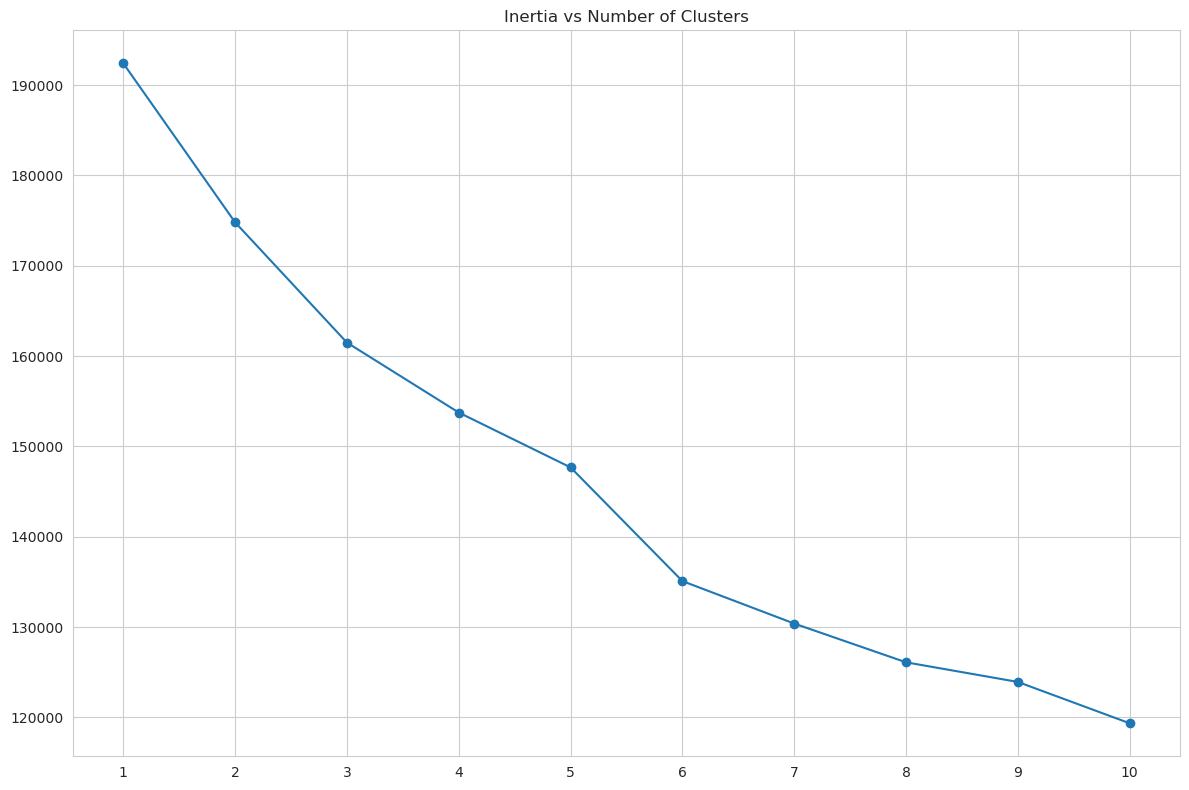

In [35]:
# Convert the scaled data into a DataFrame for compatibility with KMeans algorithm
X = pd.DataFrame(X_scaled)

# Initialize an empty list to store the inertia values for different cluster counts
inertias = []

# Loop through a range of k values from 1 to 10 to find the optimal number of clusters
for k in range(1, 11):
    # Initialize the KMeans algorithm with the current number of clusters
    model = KMeans(n_clusters=k)
    # Fit the model to the data and predict the clusters; store the output in y (unused)
    y = model.fit_predict(X)
    # Append the inertia of the model (sum of squared distances of samples to their closest cluster center) to the inertias list
    inertias.append(model.inertia_)
    
# Create a new figure for plotting with a specified figure size
plt.figure(figsize=(12, 8))

# Plot the inertia values against the number of clusters
plt.plot(range(1, 11), inertias, marker='o')

# Set the x-axis ticks to correspond to the number of clusters
plt.xticks(ticks=range(1, 11), labels=range(1, 11))

# Set the title of the plot to 'Inertia vs Number of Clusters'
plt.title('Inertia vs Number of Clusters')

# Adjust the layout to ensure the labels and title fit without overlap
plt.tight_layout()

# Display the plot
plt.show()


It looks like the rate of decreasing of the inertia slows down between 5 and 7 clusters. We'll use 6 clusters to move on.


In [13]:
model = KMeans(n_clusters=6)
y = model.fit_predict(X_scaled)

y

array([0, 0, 0, ..., 3, 3, 0], dtype=int32)

# Analyzing Results

Now, let's create a `CLUSTER` column in our original dataset so we can better understand the characteristics of each one.

In [14]:
customers['CLUSTER'] = y + 1
customers

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,CLUSTER
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,1
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,1
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,5
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,2
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,4
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,4


In [15]:
customers['CLUSTER'].value_counts()

2    2281
4    2186
1    2024
3    1367
6    1338
5     931
Name: CLUSTER, dtype: int64

We can see that cluster 2 is the largest while cluster 3 is the smallest.

Considering the numeric variable only, we'll check on the average value of each variable per cluster. We just need to group the data and plot a bar chart for each column.

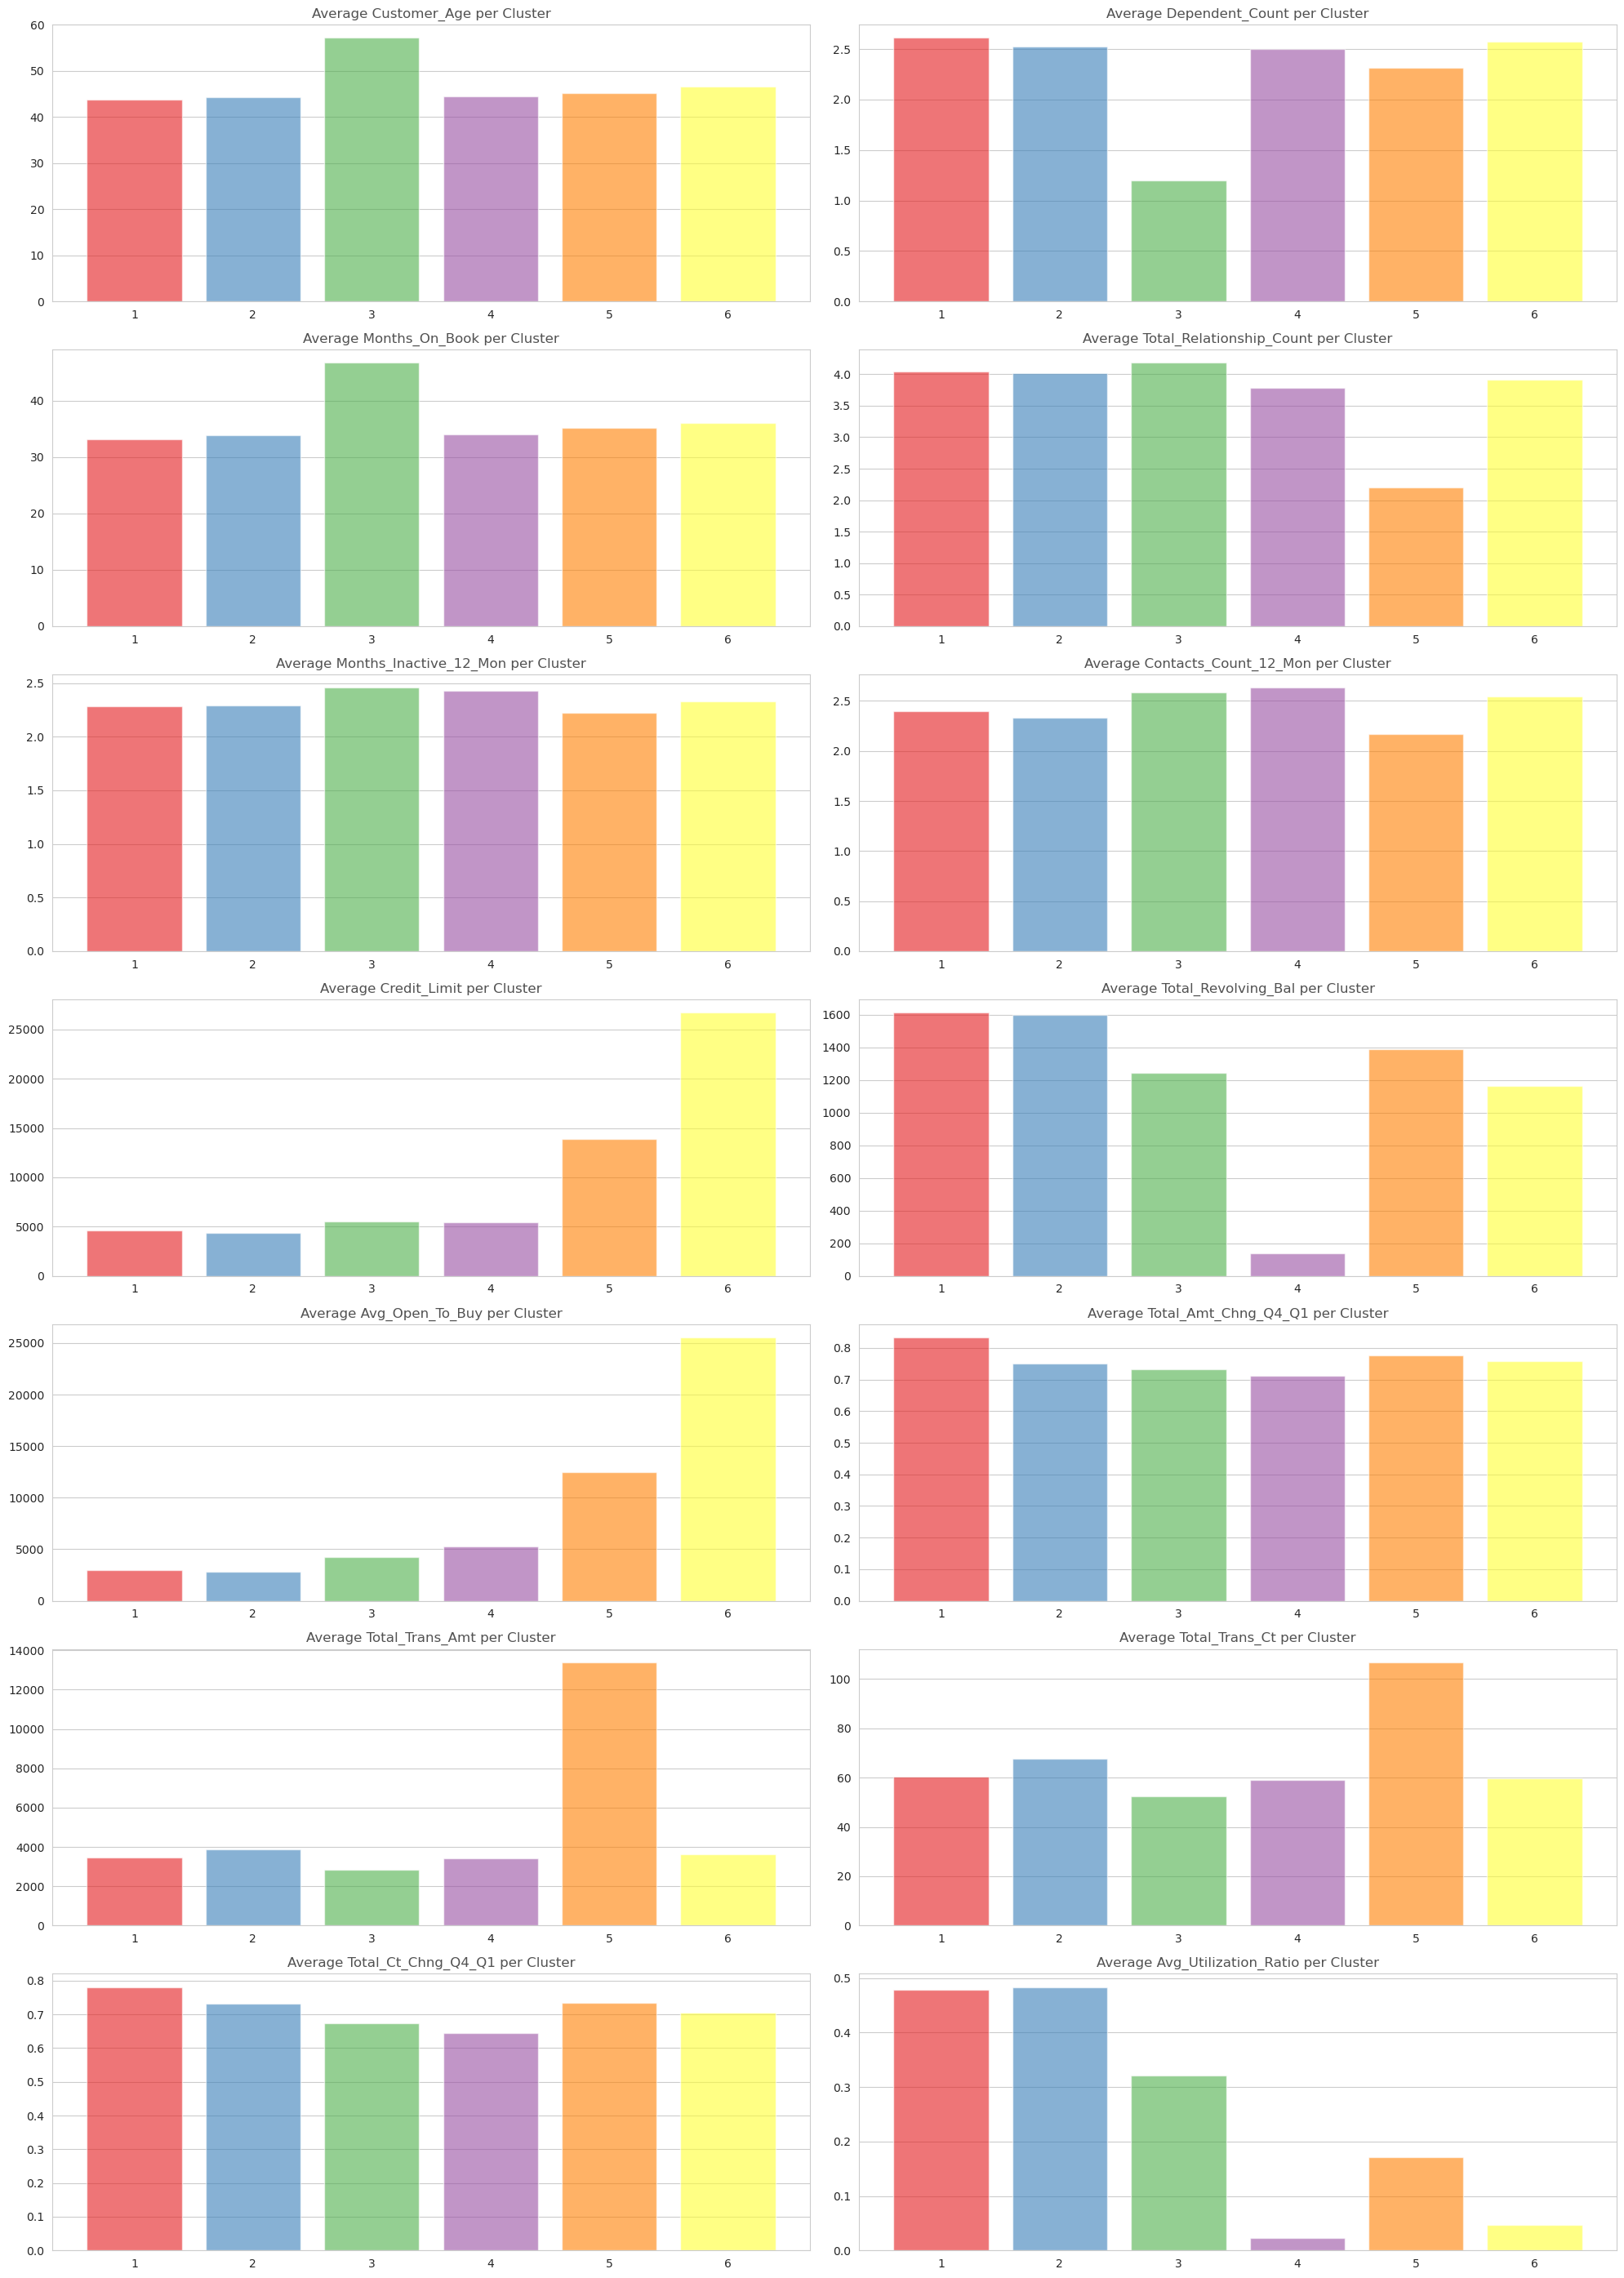

In [16]:
# Make sure you have the correct column names for 'customer_id' and 'CLUSTER'
numeric_columns = customers.select_dtypes(include=np.number).drop(['CLIENTNUM', 'CLUSTER'], axis=1).columns

# Calculate the number of rows needed for subplots based on the number of numeric columns
n_rows = int(np.ceil(len(numeric_columns) / 2))

# Initialize the figure with the calculated number of rows
fig = plt.figure(figsize=(20, n_rows * 4))  # The height of each subplot is roughly estimated as 4

for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(n_rows, 2, i+1)  # Ensure the subplot fits into the calculated grid
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.8)  # Increase alpha for better readability
    ax.xaxis.grid(False)  # Optionally, remove this line if you want to show the x-axis grid
    
plt.tight_layout()
plt.show()


For those numerical variables with higher correlations we saw earlier, we can also use a scatter plot to visualize this correlation grouped by clusters and analyze how the clusters change between each area of the chart.

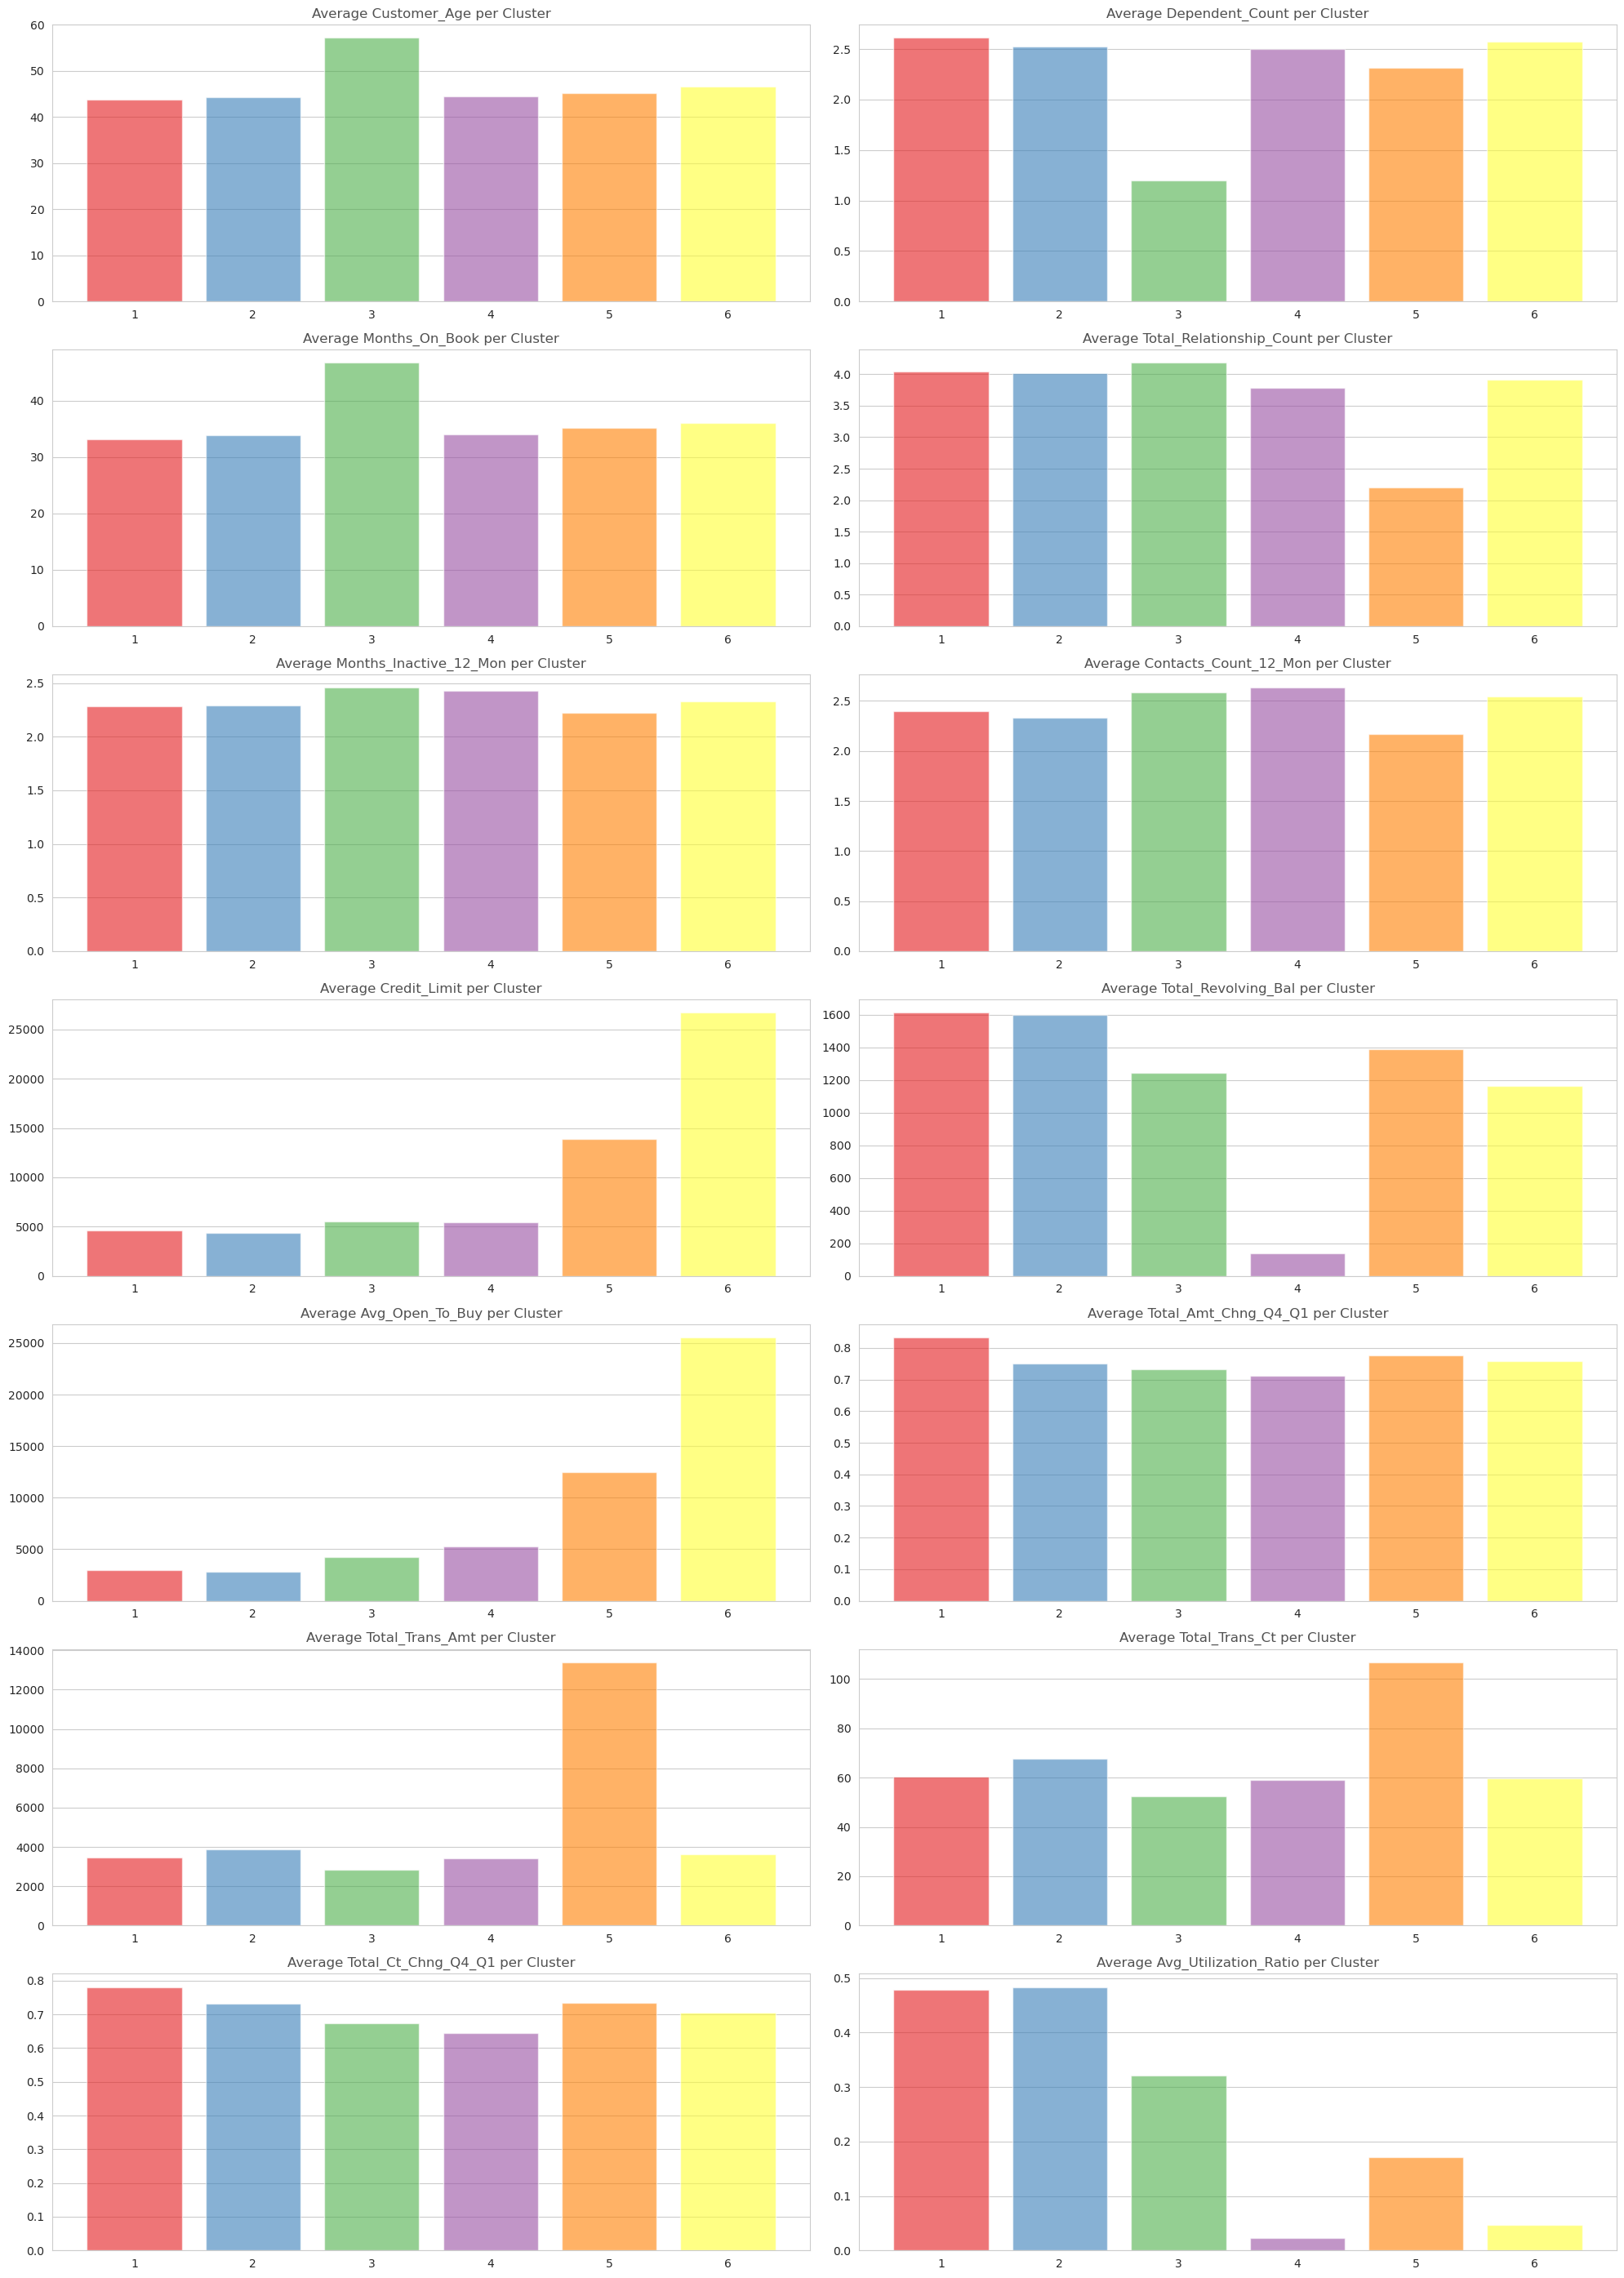

In [21]:
# Make sure you have the correct column names for 'customer_id' and 'CLUSTER'
numeric_columns = customers.select_dtypes(include=np.number).drop(['CLIENTNUM', 'CLUSTER'], axis=1).columns

# Calculate the number of rows needed for subplots based on the number of numeric columns
n_rows = int(np.ceil(len(numeric_columns) / 2))

# Initialize the figure with the calculated number of rows
fig = plt.figure(figsize=(20, n_rows * 4))  # The height of each subplot is roughly estimated as 4

for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(n_rows, 2, i+1)  # Ensure the subplot fits into the calculated grid
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.8)  # Increase alpha for better readability
    ax.xaxis.grid(False)  # Optionally, remove this line if you want to show the x-axis grid
    
plt.tight_layout()
plt.show()

We can draw some early conclusions considering only the numeric variables.

For instance, Cluster 1 has the highest amount of money transitioned, while Cluster 2 has the lowest credit limit and estimated income and the highest utilization rate. Cluster 4 has the highest credit limit. Older clients are grouped in Cluster 5.

For the categorical columns, we'll plot the percentual distribution of each variable in each cluster. This will allow us to verify if a particular cluster is mostly composed of men, or of married people only, for example.

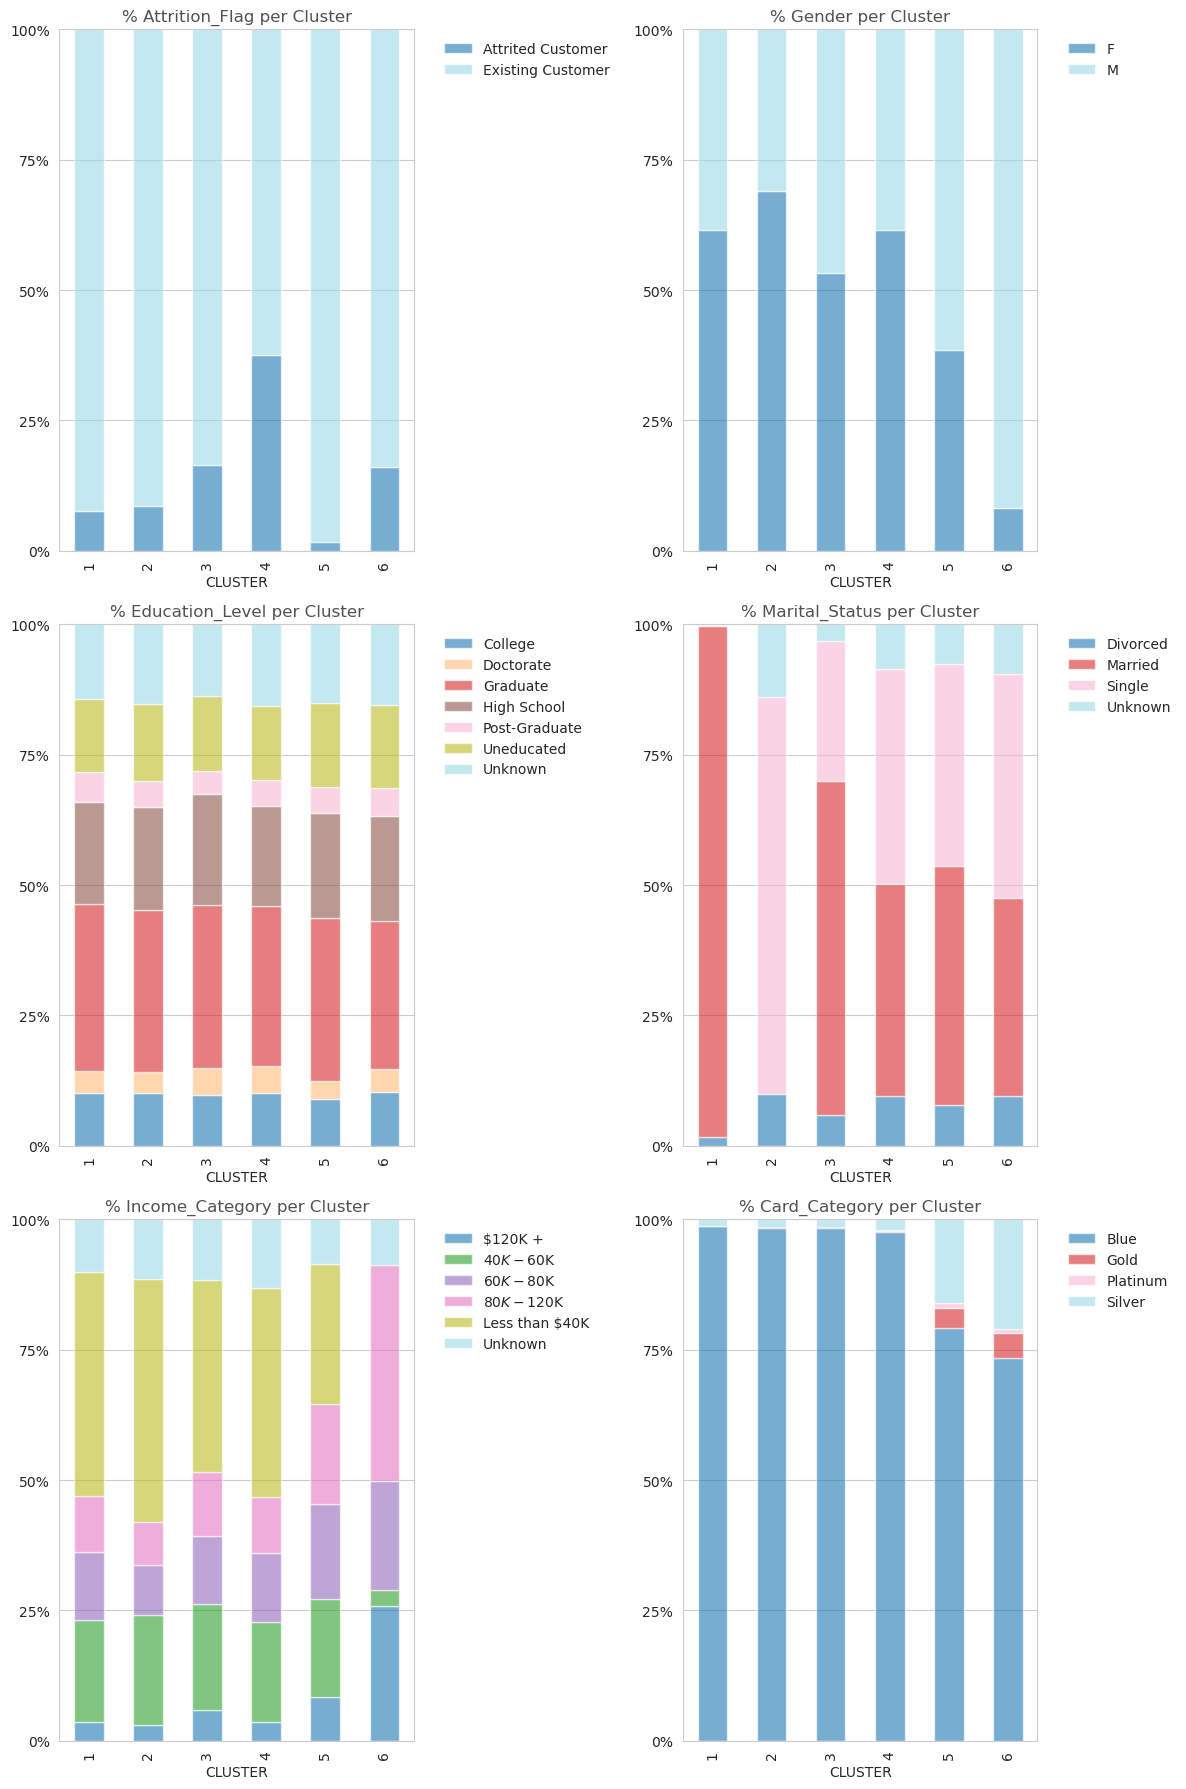

In [31]:
# Assuming 'customers' DataFrame is already loaded and contains a 'CLUSTER' column
cat_columns = customers.select_dtypes(include=['object']).columns

# Calculate the required number of rows: two plots per row
n_cols = 2
n_rows = (len(cat_columns) + 1) // n_cols  # Ensure we have enough rows

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 6 * n_rows))  # Adjusted figsize based on the number of rows

for i, col in enumerate(cat_columns):
    row = i // n_cols
    col_idx = i % n_cols
    ax = axs[row, col_idx]
    
    plot_df = pd.crosstab(index=customers['CLUSTER'], columns=customers[col], normalize='index')
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6, colormap='tab20')
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.8)

    ax.set_ylim(0, 1)
    ax.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.xaxis.grid(False)
    
    # Set a fixed number of ticks (e.g., 5 ticks)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    
    # Set y-axis labels to represent percentages
    ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])

# Hide any unused axes if the number of categorical columns is odd
if len(cat_columns) % n_cols:
    axs[-1, -1].axis('off')

plt.tight_layout()
plt.show()


The clusters show distinct patterns in terms of customer attributes like marital status, income, and credit card usage behavior. Based on these visualizations, let's elaborate on the insights and how they could be interpreted:

### Cluster 1
- **Characteristics**: Predominantly male with a higher credit limit, which suggests a higher level of trust from the issuer. There are high transaction amounts and counts, but the low utilization ratio implies they have access to significant credit but use a relatively small portion of it.
- **Insight**: These customers seem financially comfortable and responsible with credit. Encouraging them with rewards for frequent usage could increase their card activity, benefiting from interchange fees for the issuer.

### Cluster 2
- **Characteristics**: Comprised mostly of women, with many being married. They have lower estimated incomes and credit limits but show high utilization rates.
- **Insight**: This group appears to rely more on credit for their spending, perhaps due to lower income. They might be sensitive to interest rates and fees. Offering financial management tools and tailored credit offers could foster loyalty.

### Cluster 3
- **Characteristics**: A balanced gender mix, lower credit limits, high utilization rates, and a marital status predominantly unknown.
- **Insight**: This cluster's high utilization with lower credit limits might indicate a potential risk for default. Financial education services and credit monitoring could be beneficial offerings for them.

### Cluster 4
- **Characteristics**: Largely men, with many being single or married, who have high estimated incomes and high credit limits. Despite these factors, they have low transaction amounts and utilization rates.
- **Insight**: This group could be targeted with premium card offerings that provide perks and rewards for spending, which might encourage more frequent use of their cards.

### Cluster 5
- **Characteristics**: Mainly married and older customers, who are long-standing clients with low dependent counts. They have low credit limits and transaction amounts but high utilization rates.
- **Insight**: Loyalty programs and senior discounts could be effective in retaining these customers and potentially increasing their spend.

### Cluster 6
- **Characteristics**: Predominantly women and entirely single, with low estimated income and credit limits. Despite this, they show high utilization rates.
- **Insight**: There could be opportunities to offer credit-building products or services that cater to this demographic. Considerations for small credit line increases could be evaluated based on good payment history.


In [33]:
# List of customers and clusters
customers[['CLIENTNUM', 'CLUSTER']]

,CLIENTNUM,CLUSTER
0,768805383,1
1,818770008,1
2,713982108,1
3,769911858,1
4,709106358,1
...,...,...
10122,772366833,5
10123,710638233,2
10124,716506083,4
10125,717406983,4
